<h1>Proveedor DIAS sobloo - Ejemplo parcela Baleares</h1>

Realizado en conferencia Panta Rhei 5/10/2018.

<h3>Información de los indicadores</h3>
Información extraida de <a href='http://www.intelligence-airbusds.com/biophysicalparameters/'>http://www.intelligence-airbusds.com/biophysicalparameters/</a>.

<table style="text-align='left'">
<tr>
    <th style='text-align:left'>Name</th>
    <th style='text-align:left'>Meaning</th>
    <th style='text-align:left'>Value</th>
    <th style='text-align:left'>Interest</th>
</tr>
<tr>
    <td style='text-align:left'><b>fCover</b> (fractional cover of green vegetation)</td>
    <td style='text-align:left'>% of surface of the ground occupied by the plant, seen from above</td>
    <td style='text-align:left'>0 to 1, 1 corresponding to a situation where the ground is completely covered by vegetation</td>
    <td style='text-align:left'>Mixed with other indicators, gives access to biomass assessment</td>
    
</tr>
<tr>
    <td style='text-align:left'><b>fNPV</b> (fractional cover of non photosynthetic – brown – vegetation)</td>
    <td style='text-align:left'>% of surface of the ground occupied by brown leaves, seen from above</td>
    <td style='text-align:left'>It ranges from 0 to 1, 1 corresponding to a situation where the ground would be completely covered by brown vegetation</td>
    <td style='text-align:left'>May indicate stress or a certain degree of senescence / maturity in the crop. Can be used to issue recommendations for harvest or irrigation</td>
</tr>
</table>

No hay información en la página sobre el indicador <b>fSoil</b>.

In [9]:
# Imports

import numpy as np
import os
import re
from datetime import datetime
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from keras.preprocessing.image import img_to_array
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
# Creamos un dataframe en memoria para albergar toda la información

# Se espera el directorio con la información en el directorio actual
DATA_DIR = os.path.abspath('./cfde75f0-50c4-46c5-b3be-e812a57875f6/')

dates = pd.date_range('2017-10-07', '2018-09-30')
satellites = ['SENTINEL2A', 'SENTINEL2B', 'LANDSAT8']
cols = ['image', 'FCOVER_mean', 'FCOVER_median', 'FCOVER_variance', 'FCOVER_validity', 
        'FNPV_mean', 'FNPV_median', 'FNPV_variance', 'FNPV_validity',
        'FSOIL_mean', 'FSOIL_median', 'FSOIL_variance', 'FSOIL_validity']
index = pd.MultiIndex.from_product([dates, satellites], names=('date', 'satellite'))
df = pd.DataFrame(index = index, columns = cols)

In [3]:
# Leemos la información de los ficheros stats.json y poblamos el dataframe

dirs = os.listdir(DATA_DIR)
for dir in dirs:
    if os.path.isdir(os.path.join(DATA_DIR, dir)):
        # Extraemos la fecha y el nombre del satélite del nombre del directorio
        match = re.match('(\d{8})-(.*)', dir)
        date = datetime.strptime(match.group(1), '%Y%m%d')
        satellite = match.group(2)
        tif_file = os.path.join(DATA_DIR, dir, 'FIELDIMAGE', 'DISPLAY.tif')
        tif_image = Image.open(tif_file)
        tif_array = img_to_array(tif_image)
        df.loc[date, satellite]['image'] = tif_array
        for index in (['FCOVER', 'FNPV', 'FSOIL']):
            json_file = os.path.join(DATA_DIR, dir, index, 'stats.json')
            if os.path.exists(json_file):
                with open(json_file) as f:
                    data = json.load(f)
                    df.loc[date, satellite][index+'_mean'] = data['mean']
                    df.loc[date, satellite][index+'_median'] = data['median']
                    df.loc[date, satellite][index+'_variance'] = data['variance']
                    df.loc[date, satellite][index+'_validity'] = data['validity']
df.reset_index(inplace=True)

In [6]:
# Función que muestra la evolución de los indicadores fCover, fSoil y fNPV para una
# cierta serie temporal correspondiente a uno o más satélites

def plot_indexes(df, satellite):
    sns.set_context("notebook", font_scale=1.5)
    fig, ax = plt.subplots(figsize=(20,6))
    
    ax.set_title(satellite)
    ax.plot(df.date, df.FCOVER_mean, marker='o', ms=8, color='g', label='fCover')
    ax.plot(df.date, df.FSOIL_mean, marker='o', ms=8, color='sienna', label='fSoil')
    ax.plot(df.date, df.FNPV_mean, marker='o', ms=8, color='orange', label='fNPV')
    ax.xaxis.set_tick_params(labelsize=13)
    ax.legend()
  

<h2>Plots de series temporales de indicadores</h2>

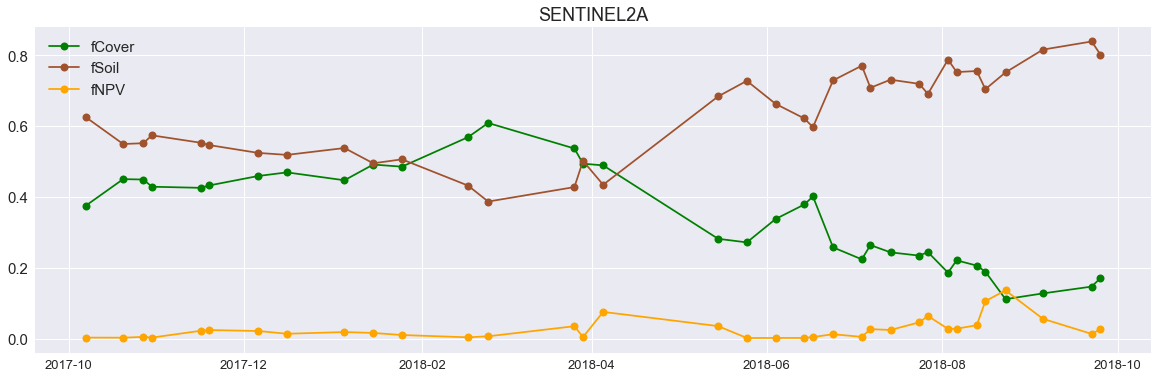

In [14]:
# Serie temporal para SENTINEL2A
sentinel2a = df[df.satellite=='SENTINEL2A'].dropna()
plot_indexes(sentinel2a, 'SENTINEL2A')

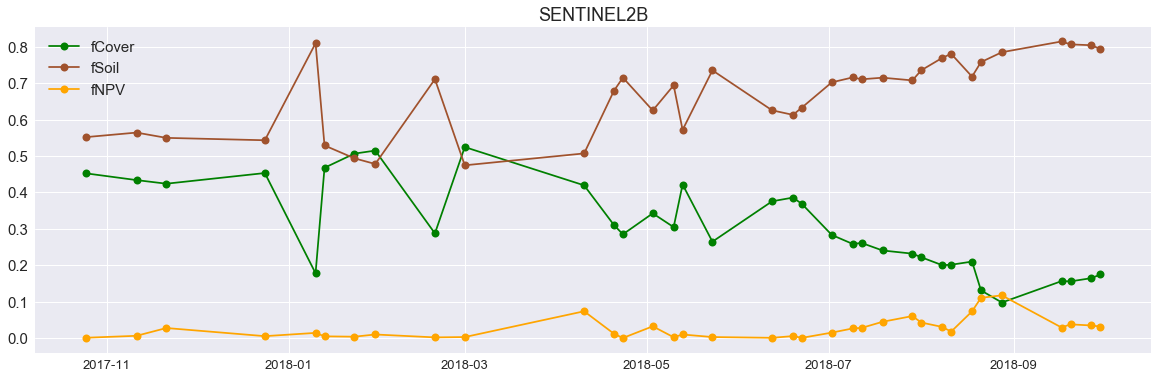

In [15]:
# Serie temporal para SENTINEL2B
sentinel2b = df[df.satellite=='SENTINEL2B'].dropna()
plot_indexes(sentinel2b, 'SENTINEL2B')

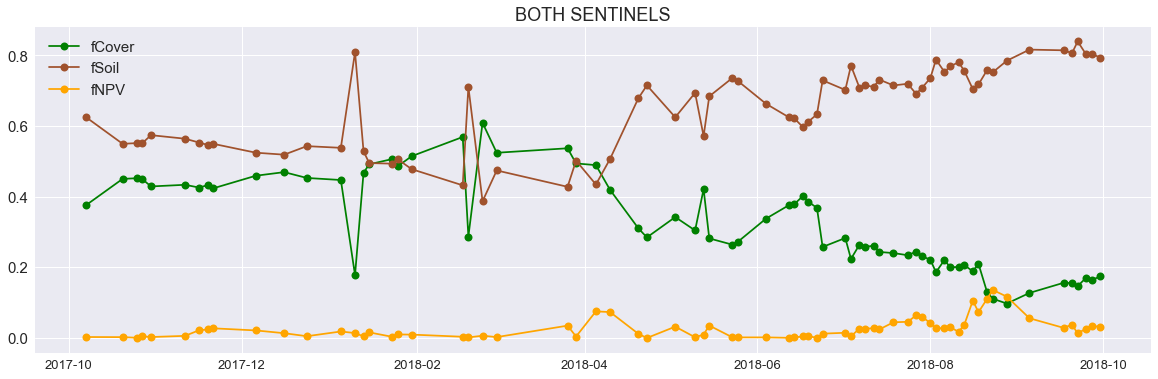

In [16]:
# Serie temporal para los dos satélites SENTINEL combinados
sentinel = df[(df.satellite=='SENTINEL2A') | (df.satellite=='SENTINEL2B')].dropna()
plot_indexes(sentinel, 'BOTH SENTINELS')

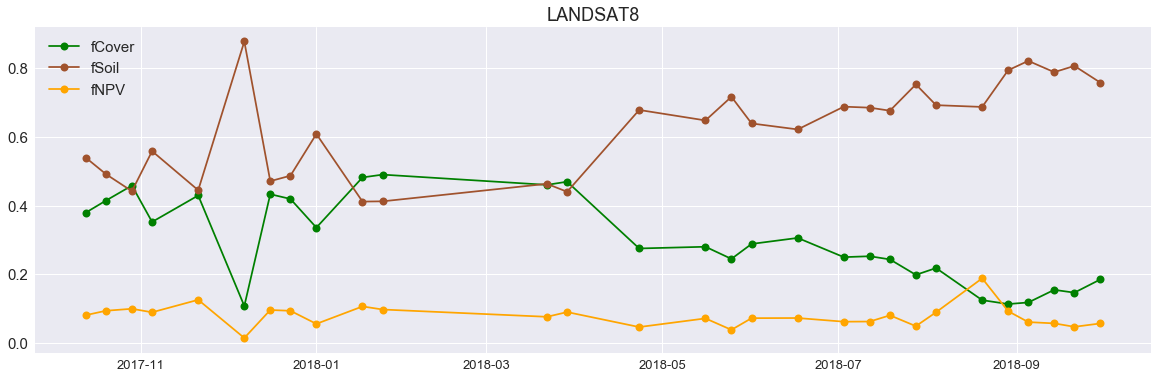

In [17]:
# Serie temporal para LANDSAT8
landsat8 = df[df.satellite=='LANDSAT8'].dropna()
plot_indexes(landsat8, 'LANDSAT8')

<h2>Animaciones de imágenes para cada satélite</h2>

In [18]:
from IPython.display import display, HTML
from matplotlib import animation

def plot_movie_mp4(image_array):
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

In [22]:
image_array = np.stack(df[df.satellite=='SENTINEL2A']['image'].dropna())
plot_movie_mp4(image_array);

In [23]:
image_array = np.stack(df[df.satellite=='SENTINEL2B']['image'].dropna())
plot_movie_mp4(image_array);

In [24]:
image_array = np.stack(df[df.satellite=='LANDSAT8']['image'].dropna())
plot_movie_mp4(image_array);